In [1]:
import os
import copy
import glob

import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt

import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from pyuvdata import UVData
from hera_cal import redcal

In [2]:
# Locate data
dfiles = sorted(glob.glob("/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458111/zen.2458111.30???.xx.HH.uvOCRS"))

In [3]:
%%time
# Initialize UVData object to read and contain MIRIAD information
uvd = UVData()
uvd.read_miriad(dfiles)

# Apply flags
uvd.data_array *= np.logical_not(uvd.flag_array)

# Intialize a cosmology and a beam
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Convert to cosmological units (mK)
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol="xx")
uvd.data_array *= Jy_to_mK[None, None, :, None]

# Shift data and load datasets
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

CPU times: user 16.4 s, sys: 3.67 s, total: 20.1 s
Wall time: 20.3 s


In [4]:
%%time
# Phase data (What does this do?)
ds.rephase_to_dset(0)

CPU times: user 4.39 s, sys: 28 ms, total: 4.41 s
Wall time: 4.43 s


In [5]:
%%time
# Categorize baselines into physical separation length
BIN_WIDTH = 0.3
NORM_BINS = np.arange(0.0, 10000.0, BIN_WIDTH)

antpos = {ant: pos for ant, pos in zip(uvd.get_ENU_antpos()[1], uvd.get_ENU_antpos()[0])}

redundant_groups = redcal.get_pos_reds(antpos, bl_error_tol=1.0, low_hi=True)
xants1, xants2 = hp.utils.calc_reds(uvd1, uvd2)[3:]
xants = np.unique(xants1 + xants2)

reds = {}
for group in redundant_groups:
    for antpair in group:
        ant0 = antpair[0]
        ant1 = antpair[1]
        if (ant0 in xants) or (ant1 in xants) or (ant0 >= ant1):
            continue
        norm = np.linalg.norm(antpos[ant0] - antpos[ant1])
        norm = np.round(np.digitize(norm, NORM_BINS) * BIN_WIDTH, 1)
        
        if norm in reds:
            reds[norm].append(antpair)
        else:
            reds[norm] = [antpair]
norms = sorted(reds.keys())

CPU times: user 1.4 s, sys: 12 ms, total: 1.41 s
Wall time: 1.45 s


In [6]:
%%time
# Initialize UVPspec objects for each baseline bin
uvps = [] 
for norm in norms:
    uvp = ds.pspec(
        reds[norm],
        reds[norm],
        (0, 1),
        pols=("xx", "xx"),
        spw_ranges=[(580,680)],
        taper="blackman-harris",
        verbose=False)
    uvps.append(uvp)

CPU times: user 47min 31s, sys: 1h 22min 30s, total: 2h 10min 2s
Wall time: 16min 27s


In [7]:
%%time
# Average each UVPspec object in time and baseline bin and fold into wedge
for uvp, norm in zip(uvps, norms):
    blpairs = [[(bl, bl) for bl in reds[norm]]]
    uvp.average_spectra(blpair_groups=blpairs, time_avg=True)
    uvp.fold_spectra()
    uvp.data_array[0] = uvp.data_array[0].reshape(
        (len(uvp.freq_array)))[np.nonzero(uvp.data_array[0].reshape((len(uvp.freq_array))))]

CPU times: user 352 ms, sys: 11 ms, total: 363 ms
Wall time: 405 ms


In [26]:
# Load data from UVPspec objects into an array
wedge = np.array([uvp.data_array[0] for uvp in uvps])

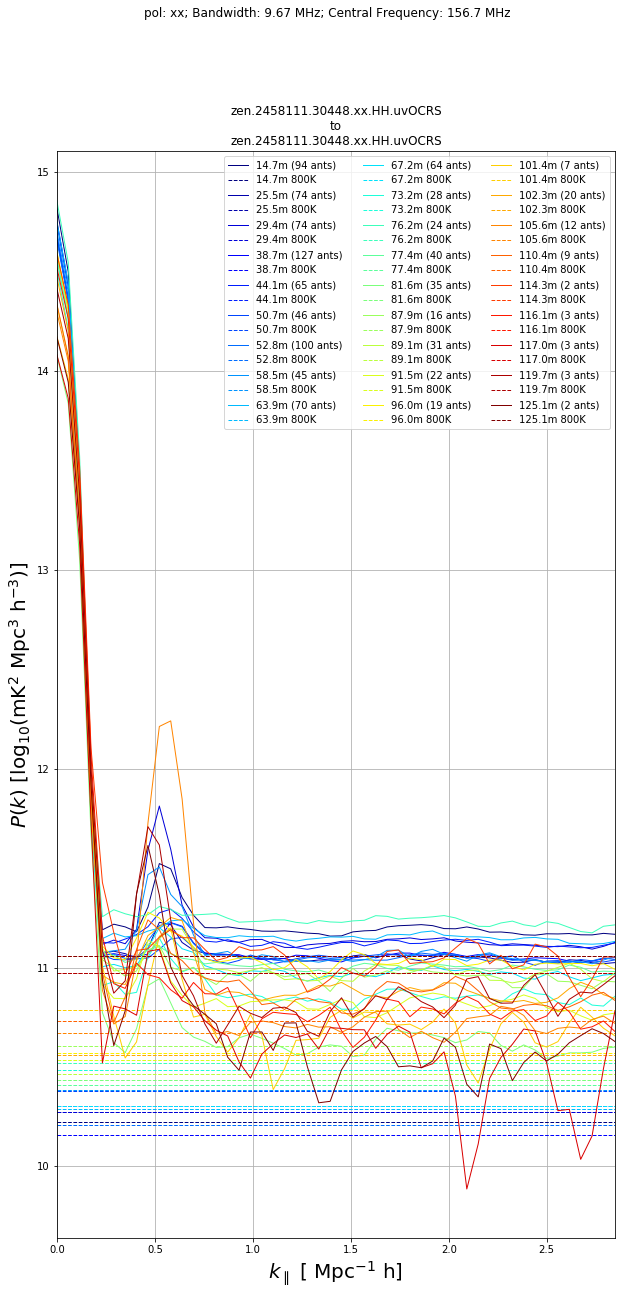

In [28]:
"""Plotting"""
def get_cmap(n, name='jet'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(len(uvps))

# Make a copy of a uvp object to get freq_array and kparas
UVP = copy.deepcopy(uvps[0])

# Find bandwidth and central frequency in MHz for naming
BAND_START = (UVP.freq_array[0] * u.Hz).to(u.MHz)
BAND_STOP = (UVP.freq_array[-1] * u.Hz).to(u.MHz)
BANDWIDTH = (BAND_STOP - BAND_START)
CENTRAL_FREQ = ((BANDWIDTH / UVP.Nfreqs) + BAND_START)

# Generate x-values to plot against
kparas = (UVP.get_kparas(0)/u.Mpc).insert(0, 0)

Tsys = 800
plt.figure(figsize=(10, 20))
for i, (uvp, norm, pspec) in enumerate(zip(uvps, norms, wedge)):
    plt.plot(
        kparas,
        np.log10(np.abs(pspec)),
        c=cmap(i),
        ls='-',
        lw=1,
        label='{norm}m ({ants} ants)'.format(norm=norm, ants=len(reds[norm])))

    noise = uvp.generate_noise_spectra(0, 'xx', Tsys)
    noise = noise[noise.keys()[0]]
    noise = np.insert(noise, 0, noise[0, 0], axis=1)
    noise = noise.reshape(len(kparas))
    noise = np.log10(noise)
    plt.plot(
        kparas,
        noise,
        c=cmap(i),
        ls='--',
        lw=1,
        label='{norm}m {Tsys}K'.format(norm=norm, Tsys=Tsys))
    
    
plt.legend(loc='upper right', ncol=3)

# x-axis
plt.xlim((0, UVP.get_kparas(0)[-1]))
plt.xlabel(r"$k_{\parallel}\ [\rm\ Mpc^{-1}\ h]$", size=20)

# y-axis
# plt.ylim((0, 20))
plt.ylabel(r"$P(k)\ \rm [\log_{10}({mK^2\ Mpc^3\ h^{-3}})]$", size=20)

# Titles
plt.suptitle("pol: xx; Bandwidth: {BW}; Central Frequency: {CF}".format(
    BW=np.round(BANDWIDTH, 2),
    CF=np.round(CENTRAL_FREQ, 1)))
plt.title(os.path.basename(dfiles[0]) + "\nto\n" + os.path.basename(dfiles[-1]))

# Save and show the plot with a grid
plt.grid()
plt.savefig("xx.{BW}_{CF}.{JD0}_{JDf}{DFext}.pdf".format(
    BW=np.round(BANDWIDTH.value, 2),
    CF=np.round(CENTRAL_FREQ.value, 1),
    JD0=dfiles[0].split(".")[2],
    JDf=dfiles[-1].split(".")[2],
    DFext=os.path.splitext(dfiles[0])[1]))
plt.show()

In [9]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.log10(np.abs(wedge)), interpolation="nearest", aspect="auto")

# plt.tick_params(axis='both', direction='inout')

# plt.xticks([])
# plt.xlabel(str(norms[i]) + " m", rotation=45, ha="center")

# horizon = ((norms[i]*u.m / c.c).to(u.ns)).value
# plt.axhline(y=horizon, color="w", ls=":")
# plt.axhline(y=-horizon, color="w", ls=":")

# plt.ylim((uvp.get_dlys(0)[0]*1e9 / 2., uvp.get_dlys(0)[-1]*1e9 / 2.))
    
# plt.text(0.07, 0.5, r"$\tau$ [ns]", ha="center", rotation="vertical", size=20)
# plt.text(0.5, 0.04, "Redundant Baseline Group", ha="center", size=20)
# plt.subplots_adjust(wspace=0, hspace=0)
# cbar_ax = fig.add_axes([0.9125, 0.25, 0.025, 0.5])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=20, ha='center')
# plt.show()
# plt.clf()